# CS5670 Project 5 Notebook - Convolutional Neural Networks

Welcome to Project 5 Notebook! In this project, you will learn:

1. Basic use of the PyTorch deep learning library
2. How to build and understand neural network models in PyTorch
3. How to backpropagate through the network w.r.t the image
4. How to generate adversarial examples

If this is your first time working with PyTorch, **please go through the "What is PyTorch" and "Neural Networks" tutorials in [Deep Learning with PyTorch: A 60 Minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)**. It won't take too long, but you will learn a lot and make this assignment much easier! You can use a new Colab notebook for the tutorials.

# Intro

## Installation of Dependencies

Run the below cell to install PyTorch for this notebook

In [7]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


## Useful Functions

Run the below cell to initialize the provided functions that will be used in this assignment

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable

import urllib
import cv2
import numpy as np
import os, sys,  math, random, subprocess
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from io import StringIO
import PIL.Image

# Configure matplotlib to render inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

    
def get_n_params(module):
  nparam = 0
  for name, param in module.named_parameters():
    param_count = 1
    for size in list(param.size()):
      param_count *= size
    nparam += param_count
  return nparam

def get_model_params(model):
  nparam = 0
  for name, module in model.named_modules():
    nparam += get_n_params(module)
  return nparam

def np_img_from_url(url):
  url_response = urllib.urlopen(url)
  img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, -1)
  return img

def to_numpy_image(tensor_or_variable):
  
  # If this is already a numpy image, just return it
  if type(tensor_or_variable) == np.ndarray:
    return tensor_or_variable
  
  # Make sure this is a tensor and not a variable
  if type(tensor_or_variable) == Variable:
    tensor = tensor_or_variable.data
  else:
    tensor = tensor_or_variable
  
  # Convert to numpy and move to CPU if necessary
  np_img = tensor.data.cpu().numpy()
  
  # If there is no batch dimension, add one
  if len(np_img.shape) == 3:
    np_img = np_img[np.newaxis, ...]
  
  # Convert from BxCxHxW (PyTorch convention) to BxHxWxC (OpenCV/numpy convention)
  np_img = np_img.transpose(0, 2, 3, 1)
  
  return np_img


def to_pytorch_image(np_image):
  
  # Create a batch dimension
  if len(np_image.shape) == 3:
    np_image = np_image[np.newaxis, ...]
  
  # Convert from BxHxWxC (OpenCV/numpy) to BxCxHxW (PyTorch)
  np_image = np_image.transpose(0, 3, 1, 2)
  
  pytorch_img = torch.from_numpy(np_image).float()
  
  return pytorch_img
  
def draw_border(image_np, color):
  color = np.asarray(color)
  s = image_np.shape
  image_np = image_np.copy()
  image_np[0:5, :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, 0:5, :] = color[np.newaxis, np.newaxis, :]
  image_np[s[0]-5:s[0], :, :] = color[np.newaxis, np.newaxis, :]
  image_np[:, s[0]-5:s[0], :] = color[np.newaxis, np.newaxis, :]
  return image_np

def normalize_zero_one_range(tensor_like):
  x = tensor_like - tensor_like.min()
  x = x / (x.max() + 1e-9)
  return x


def prep_for_showing(image):
  np_img = to_numpy_image(image)
  if len(np_img.shape) > 3:
    np_img = np_img[0]
  np_img = normalize_zero_one_range(np_img)
  return np_img

  
def show_image(tensor_var_or_np, title=None, bordercolor=None):
  np_img = prep_for_showing(tensor_var_or_np)
  
  if bordercolor is not None:
    np_img = draw_border(np_img, bordercolor)
  
  # plot it
  np_img = np_img.squeeze()
  plt.figure(figsize=(4,4))
  plt.imshow(np_img)
  plt.axis('off')
  if title: plt.title(title)
  plt.show()
    
def show_images(images, correct_list=None, size=128, titles=None):
  for i, image in enumerate(images):
    bordercolor = ([0,1,0] if correct_list[i] else [1,0,0]) if correct_list else None
    show_image(image, bordercolor=bordercolor, title=titles[i] if titles else None)
    
def show_image_rows(image_lists):
  for l in image_lists:
    #plt.figure(figsize=(1, len(l)))
    #plt.axis('off')
    f, axarr = plt.subplots(1,len(l))
    #print(axarr)
    for i,img in enumerate(l):
      img_np = prep_for_showing(img).squeeze()
      axarr[i].imshow(img_np)
      axarr[i].axis('off')
    plt.show()

from bs4 import BeautifulSoup
import requests

def listFD(url, ext=''):
  page = requests.get(url).text
  soup = BeautifulSoup(page, 'html.parser')
  return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  
  # Convert BGR to RGB
  image = image[:, :, [2,1,0]]
  
  return image

def url_to_text(url):
  resp = urllib.request.urlopen(url)
  text = resp.read()
  return text.decode("utf-8")

## Dataset

The following cell implements a Dataset that loads the images that will be used later in this assignment.

It's a subclass of `torch.utils.data.Dataset`, which is a base class for Datasets in pytorch, and it is compatible with `torch.utils.data.Dataloader`. Dataloder is useful, because it allows us to easily load data in multiple background threads without writing any threading code. This is important, because one of the biggest bottlenecks in neural network training is the rate at which data can be fed into the model.

A dataset implements `__len__` and `__getitem__`, which means samples from the dataset can be obtained by indexing it like `sample = dataset[5]`.

A dataloader can be iterated and returns batches: `batch_0 = iter(dataloader).first()`

`torchvision` is useful suite of utilities when doing computer vision work with PyTorch. It already [provides implementations for many of the most popular computer vision datasets](http://pytorch.org/docs/master/torchvision/datasets.html). In this notebook, we have rolled our own dataset that loads images from a URL.

In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

DATA_URL = "http://www.cs.cornell.edu/courses/cs5670/2018sp/projects/pa5/assignment_data/dataset/"
IMAGENET_LABELS_URL = "http://www.cs.cornell.edu/courses/cs5670/2018sp/projects/pa5/assignment_data/imagenet_classes.txt"
DOGS_DIR = "test-dog"
FOOD_DIR = "test-food"

IMAGENET_MEAN = torch.FloatTensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.FloatTensor([0.229, 0.224, 0.225])

class FoodAndDogDataset(Dataset):
  """
  PyTorch DataLoader compatible dataset that pre-loads images from the dataset
  directory on the CS5670 class website. Images are returned as tensors, normalized
  with the imagenet normalization.
  """
  def __init__(self, include_classes="both"):
    self.dog_paths = listFD(DATA_URL + DOGS_DIR, ".jpg")
    self.food_paths = listFD(DATA_URL + FOOD_DIR, ".jpg")
    
    self.dog_labels = [0 for _ in self.dog_paths]
    self.food_labels = [1 for _ in self.food_paths]
    
    self.img_paths = []
    self.img_labels = []
    
    if include_classes in ["both", "dogs"]:
      self.img_paths += self.dog_paths
      self.img_labels += self.dog_labels
    
    if include_classes in ["both", "food"]:
      self.img_paths += self.food_paths
      self.img_labels += self.food_labels
  
    # We might not want to do this on a real dataset, if we have a lot of data.
    # In that case we would lazy-download images.
    # But for now we will pre-download them, because there's not that many
    self.all_images_np = [url_to_image(url).astype(np.float32) / 255 for url in self.img_paths]
  
    print(f"Initialized dataset: {include_classes} with {len(self.all_images_np)} images")
  
  def __len__(self):
    return len(self.img_paths)
  
  def __getitem__(self, idx):
    img_i_np = self.all_images_np[idx]
    label_i = self.img_labels[idx]

    # Convert to pytorch. Copy so that we don't keep re-normalizing the same image multiple times.
    img_i_tensor = to_pytorch_image(img_i_np.copy())

    # Pre-process the image:
    # Normalize using the mean and variance of the ImageNet dataset
    # The model was trained from this dataset
    img_i_tensor = img_i_tensor - IMAGENET_MEAN[np.newaxis, :, np.newaxis, np.newaxis].expand_as(img_i_tensor)
    img_i_tensor = img_i_tensor / IMAGENET_STD[np.newaxis, :, np.newaxis, np.newaxis].expand_as(img_i_tensor)

    assert img_i_tensor.size(2) == img_i_tensor.size(3) == 256, "Images expected to be of shape 1x3x256x256"
    
    # Take a center-crop of image, assuming the image is 256x256
    img_i_tensor = img_i_tensor[:, :, 16:240, 16:240]

    return img_i_tensor[0], label_i
    
dog_dataset = FoodAndDogDataset(include_classes="dogs")
food_dataset = FoodAndDogDataset(include_classes="food")
full_dataset = FoodAndDogDataset(include_classes="both")

Initialized dataset: dogs with 33 images
Initialized dataset: food with 25 images
Initialized dataset: both with 58 images


## ILSVRC2012 class labels

In this project, we will be using an AlexNet image-classifier model pre-trained on the ILSVRC2012 dataset. In order to understand the model's output, we need a maping from the output probabilities to the class names. We load this mapping in this cell.

In [10]:
imagenet_id_to_label = {}
labels_file = url_to_text(IMAGENET_LABELS_URL)
labels_id2word = labels_file.split("\n")[:1000]
print(labels_id2word)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 

## Notes on PyTorch

PyTorch implements many operations on Tensors (such as torch.FloatTensor or torch.LongTensor) in much the same way numpy implements operations on ndarray. Variables (torch.autograd.Variable) wrap tensors and can be used interchangeably. When an operation is performed on a Tensor, the output is a new Tensor. When it is performed on a Variable, the output is also a Variable.

All operations involving Variables automatically build a computational graph (provided the requires_grad parameter is set to True on any of the Variable's involved in the operation). This means that at any point, calling `backward` on any Variable will compute the gradient of that Variable with respect to all other Variables. Thus calling `backward` on the loss function we're trying to optimize will calculate the gradient w.r.t model parameters, allowing us to implement gradient descent.

We can also use `.backward` to calculate a gradient w.r.t the input, provided the `requires_grad` attribute on the input variable is set to true. After calling `backward`, the gradients can be accessed in the `.grad` attribute of the variable. Here is some fairly typical code that uses this functionality to access gradients with respect to an input variable:


Given input and target of type torch.FloatTensor. First we must zero gradients on any variable that already has gradients coputed. On nn.Module, this zeroes gradients of all the model parameters.
  
```
  some_model.zero_grad()
```
  
Convert the input into a variable that requires gradient
```
  input_var = Variable(input, requires_grad=True)
  target_var = Variable(target)
```
  
Call the model and calculate the loss
```
  out = some_model(input_var)
  loss = some_loss_function(out, target)
```

Run backpropagation
```
  loss.backward()
```

Access gradients of the loss with respect to the input
```
  grad_input = input_var.grad
  
  grad_input_tensor = grad_input.data
  
  grad_input_numpy = grad_input_tensor.cpu().numpy()
  
```

The underlying Tensor can be accessed as the `data` attribute given a Variable.

PyTorch implements many neural network operations in the `torch.nn` package. These are usually packaged in a `Module`, which allows for easy modular design of neural network architectures.

## AlexNet definition

Below is the `Module` that implements AlexNet, copied from the `torchvision` package, with minor modifications for easier use in this assignment. Specifically, because the original implementation uses nn.Sequential containers, the individual layers are not directly accessible. We have made them directly accessible by defining the `shortcut_modules` attribute.

In [11]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

INPLACE = False

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=INPLACE),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=INPLACE),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=INPLACE),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=INPLACE),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=INPLACE),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=INPLACE),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=INPLACE),
            nn.Linear(4096, num_classes),
        )
        
        self.module_shortcuts = {
            "conv1": self.features[0],
            "relu1": self.features[1],
            "conv2": self.features[3],
            "relu2": self.features[4],
            "conv3": self.features[6],
            "relu3": self.features[7],
            "conv4": self.features[8],
            "relu4": self.features[9],
            "conv5": self.features[10],
            "relu5": self.features[11],
            
            "fc6": self.classifier[2],
            "fc7": self.classifier[5],
            "fc8": self.classifier[6]
        }
    
        
    def __getitem__(self, layer_name):
      if layer_name in self.module_shortcuts:
        return self.module_shortcuts[layer_name]
      return None
    
    
    def shortcut_modules(self):
      for name, mod in self.module_shortcuts.items():
        yield name, mod
    
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        print("Loading pre-trained weights from model zoo")
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    model.eval()
    return model

model = alexnet(pretrained=True, num_classes=1000)

Loading pre-trained weights from model zoo


# Student TODO Implementations

Implement all of your solutions in this secion

**Answer TODO 1 here**:

1. In the visualizations for the fully connected layers, fc8 has negative values whereas fc6 and fc7 contain zero and  positive values. This happens because both fc6 and fc7 layers include a ReLU function after the linear function in the classifier. Because ReLU function generates an output x for positive x and 0 otherwise, the output of fc6 and f7 are positive or 0. On the other hand, fc8 layer does not contain the ReLU function and can therefore take on values in the negative and positive ranges.


In [26]:
def convert_ilsvrc2012_probs_to_dog_vs_food_probs(probs_ilsvrc):
    """
    Convert from 1000-class ILSVRC probabilities to 2-class "dog vs food"
    incices.  Use the variables "dog_indices" and "food_indices" to map from
    ILSVRC2012 classes to our classes.
    HINT:
    Compute "probs" by first estimating the probability of classes 0 and 1,
    using probs_ilsvrc.  Stack together the two probabilities along axis 1, and
    then normalize (along axis 1).
    :param probs_ilsvrc: shape (N, 1000) probabilities across 1000 ILSVRC classes
    :return probs: shape (N, 2): probabilities of each of the N items as being
        either dog (class 0) or food (class 1).
    """
    # in the ILSVRC2012 dataset, indices 151-268 are dogs and index 924-969 are foods
    dog_indices = range(151, 269)
    food_indices = range(924, 970)
    N, _ = probs_ilsvrc.shape
    probs = np.zeros((N, 2)) # placeholder
    
    print(sum(probs_ilsvrc))
    
    # estimate prob of classes 0 and 1
    return probs

In [0]:
def get_prediction_descending_order_indices(probs, cidx):
    """
    Returns the ordering of probs that would sort it in descending order
    :param probs: (N, 2) probabilities (computed in TODO 2)
    :param cidx: class index (0 or 1)
    :return list of N indices that sorts the array in descending order
    """
    order = range(probs.shape[0]) # placeholder
    ############################ TODO 3 BEGIN #################################
    raise NotImplementedError("TODO3)")
    ############################ TODO 3 END #################################
    return order

In [0]:
def compute_dscore_dimage(scores, image, class_idx):
    """
    Returns the gradient of s_y (the score at index class_idx) with respect to
    the image (data), ds_y / dI.  Note that this is the unnormalized class
    score "s", not the probability "p".
    :param data: (3, 227, 227) array, input image
    :param class_idx: class index in range [0, 999] indicating which class
    :param net: a caffe Net object
    :return grad: (3, 227, 227) array, gradient ds_y / dI
    """
    grad = torch.zeros_like(image) # placeholder
    ############################ TODO 4 BEGIN #################################
    raise NotImplementedError("TODO4)")
    ############################ TODO 4 END #################################
    assert tuple(grad.shape) == (1, 3, 224, 224) # expected shape
    return grad[0]

In [0]:
def normalized_sgd_with_momentum_update(image, grad, velocity, momentum, learning_rate):
    """
    THIS IS SLIGHTLY DIFFERENT FROM NORMAL SGD+MOMENTUM; READ THE NOTEBOOK :)
    Update the image using normalized SGD+Momentum.  To make learning more
    stable, normalize the gradient before using it in the update rule.
    :param image: (Variable) shape (1, 3, 224, 244) the current solution
    :param grad: (Variable) gradient of the loss with respect to the image
    :param velocity: (Variable) momentum vector "V"
    :param momentum: (float) momentum parameter "mu"
    :param learning_rate: (float) learning rate "alpha"
    :return: the updated image and momentum vector (image, velocity)
    """
    ############################ TODO 5a BEGIN #################################
    raise NotImplementedError("TODO5a)")
    ############################ TODO 5a BEGIN #################################
    return image, velocity

In [0]:
def fooling_image_gradient(target_score, orig_data, image_in, target_class, reg_lambda):
    """
    Compute the gradient for make_fooling_image (dL / dI).
    :param target_score: (Variable) holding the current score assigned to the target class
    :param orig_data: (Variable) shape (1, 3, 224, 224) holding the original image
    :param image_in: (Variable) shape (1, 3, 224, 224) hoding the current solution
    :param target_class: (int) ILSVRC class in range [0, 999]
    :param reg_lambda: (float) weight applied to the regularizer.
    """
    grad = torch.zeros_like(image) # placeholder
    ############################ TODO 5b BEGIN #################################
    raise NotImplementedError("TODO5b)")
    ############################ TODO 5b END #################################
    assert tuple(grad.shape) == (1, 3, 224, 224) # expected shape
    return grad

In [0]:
def class_visualization_gradient(target_score, image, target_class, reg_lambda):
    """
    Compute the gradient for make_class_visualization (dL / dI).
    :param target_score: (Variable) holding the current score assigned to the target class
    :param image: (Variable) shape (1, 3, 224, 224) the current solution
    :param target_class: (int) ILSVRC class in range [0, 999]
    :param regularization: (float) weight (lambda) applied to the regularizer.
    """
    grad = torch.zeros_like(image) # placeholder

    ############################ TODO 6 BEGIN #################################
    raise NotImplementedError("TODO6)")
    ############################ TODO 6 END #################################
    assert tuple(grad.shape) == (1, 3, 224, 224) # expected shape
    return grad

In [0]:
def feature_inversion_gradient(data, target_feat, current_feat, reg_lambda):
    """
    Compute the gradient for make_feature_inversion (dL / dI).
    :param data: (Variable) shape (1, 3, 224, 224) the current solution
    :param target_feat: (Variable of any shape) target features at layer l
    :param current_features: (Variable of same shape)current features at layer l
    :param reg_lambda: weight (lambda) applied to the regularizer.
    """
    grad = torch.zeros_like(data) # placeholder
    ############################ TODO 7a BEGIN (EXTRA CREDITS) #################################
    raise NotImplementedError("TODO7a)")
    ############################ TODO 7a END (EXTRA CREDITS)#################################
    assert tuple(grad.shape) == (1, 3, 224, 224) # expected shape
    
    return grad, loss.data[0], loss_target.data[0], loss_reg.data[0]

**Answer TODO 7b here (EXTRA CREDITS)**:
> (a) (EXTRA CREDITS)


> (b) (EXTRA CREDITS)



# 1. AlexNet: Visualizing Structure

The AlexNet model consists of 5 convolutional layers and three fully connected layers.
Each of these layers is encapsulated in an `nn.Module` class that has one or more trainable parameters.

We can look the shapes of each of the model parameters using the below cell:

In [12]:
model_num_params = 0

# Loop through all modules
model_num_params = get_n_params(model)
print(f"# params in AlexNet: {model_num_params}")

# Loop through the select modules that we've named:
for simple_name, module in model.shortcut_modules():
  if hasattr(module, "weight"):
    print(f"Module {simple_name} weights: {module.weight.size()} bias: {module.bias.size()}")

# params in AlexNet: 61100840
Module conv1 weights: torch.Size([64, 3, 11, 11]) bias: torch.Size([64])
Module conv2 weights: torch.Size([192, 64, 5, 5]) bias: torch.Size([192])
Module conv3 weights: torch.Size([384, 192, 3, 3]) bias: torch.Size([384])
Module conv4 weights: torch.Size([256, 384, 3, 3]) bias: torch.Size([256])
Module conv5 weights: torch.Size([256, 256, 3, 3]) bias: torch.Size([256])
Module fc8 weights: torch.Size([1000, 4096]) bias: torch.Size([1000])


### Visualizing conv1 filters

Filters in conv1 are unique in that they take RGB images as input. This means that we can visualize them as RGB images. For all other layers, we cannot view them as nice little colored squares because they are much higher dimensional.

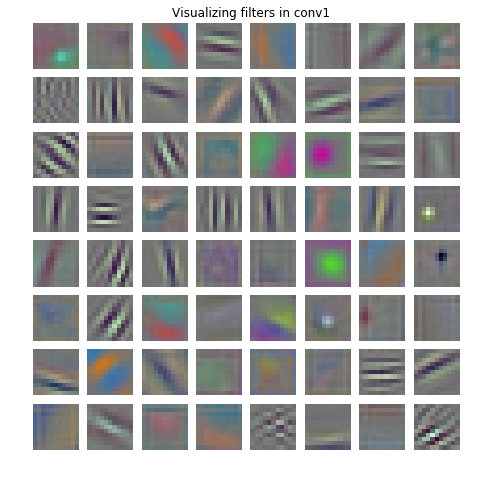

In [13]:
def vis_square(data, title=None):
    """Take a Tensor of shape (n, K, height, width) or (n, K, height, width)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    if data.size(1) > 3:
      data = data.view(-1, 1, data.size(2), data.size(3))
        
    data = to_numpy_image(data)
        
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 2), (0, 2))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    data = data.squeeze()
    
    # plot it
    plt.figure(figsize=(8, 8))
    plt.imshow(data)
    plt.axis('off')
    if title: plt.title(title)
      

weights = model.features[0].weight.data
vis_square(weights, title="Visualizing filters in conv1")

## Visualizing AlexNet activations.

PyTorch uses dynamic computational graphs. As a result of this, there is no way for us to directly access the intermediate activations as there is no fixed placeholder for them. In PyTorch, we can access intermediate activations using hooks. A forward hook is a function that gets called every time that the forward method on a module has been executed. To access intermediate activations, we register a forward hook that displays the activations.

Let's take an example image and pass it through AlexNet.

Visualize the activations inside all of these layers, using the code below. Lighter values have higher magnitude, and darker values have smaller magnitude.

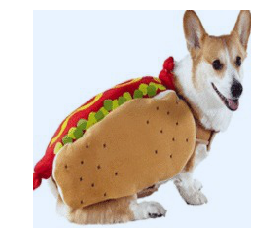

In [14]:
# Load the image of the dog
example_image, label = dog_dataset[10]
show_image(example_image)

Loading pre-trained weights from model zoo
Visualizing layer: conv1
Visualizing layer: relu1
Visualizing layer: conv2
Visualizing layer: relu2
Visualizing layer: conv3
Visualizing layer: relu3
Visualizing layer: conv4
Visualizing layer: relu4
Visualizing layer: conv5
Visualizing layer: relu5
Visualizing layer: fc6
Visualizing layer: fc7
Visualizing layer: fc8


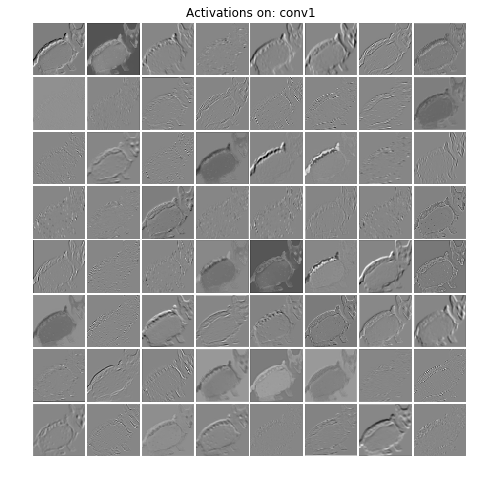

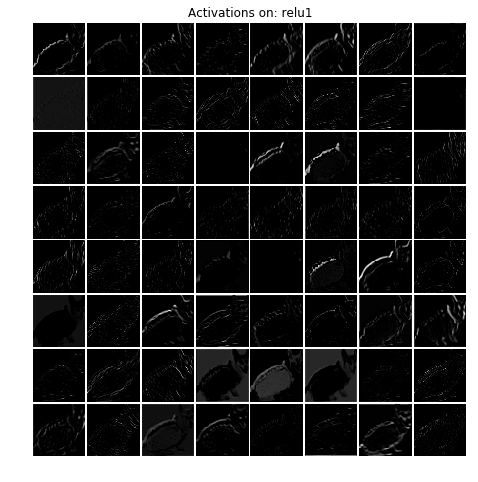

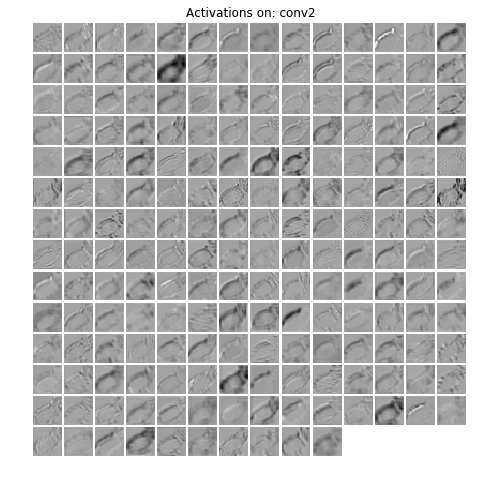

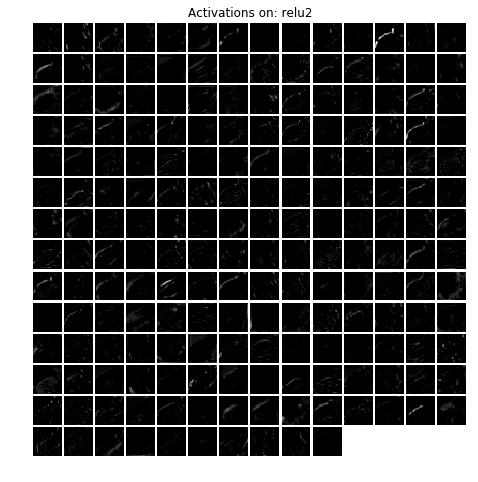

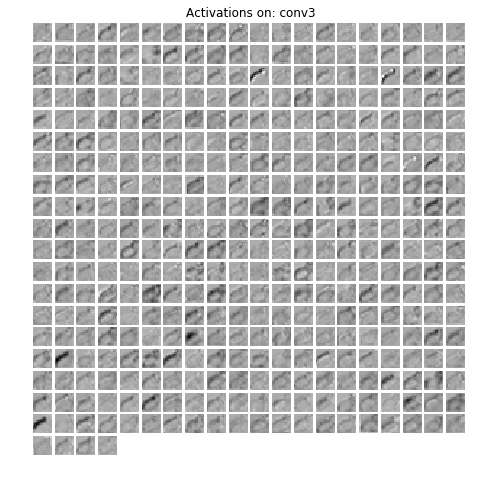

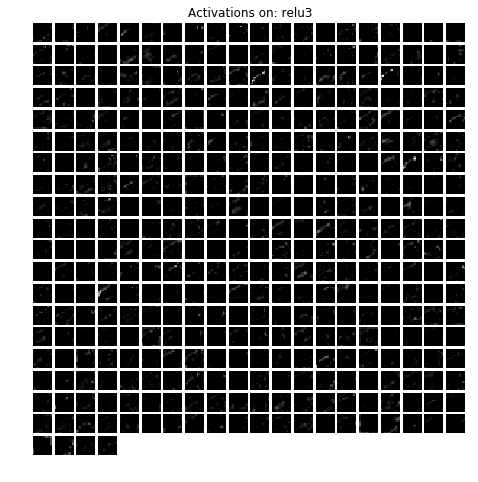

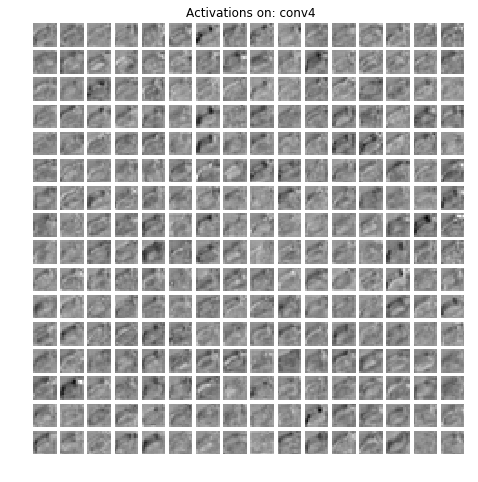

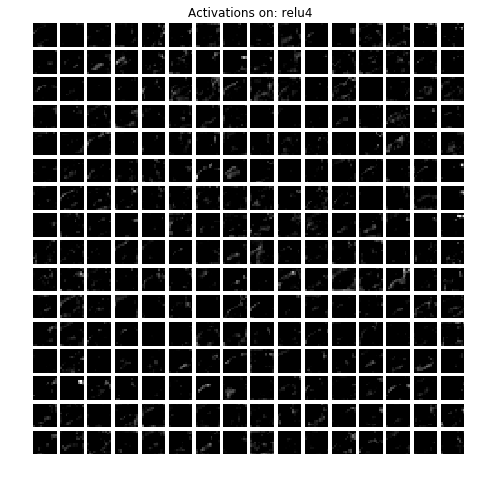

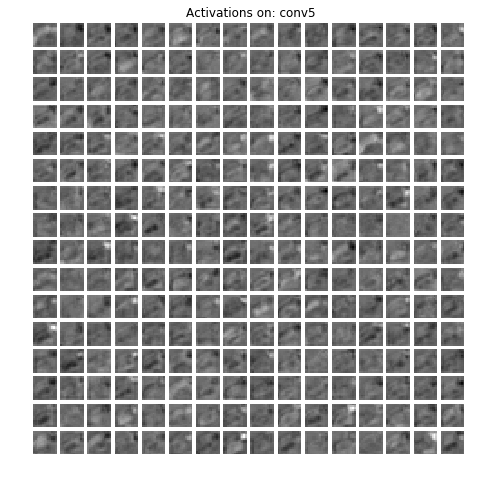

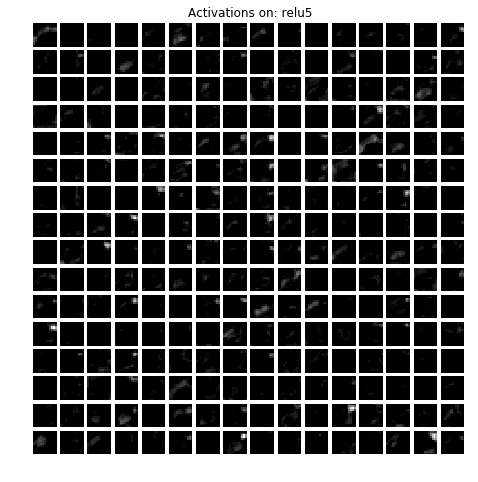

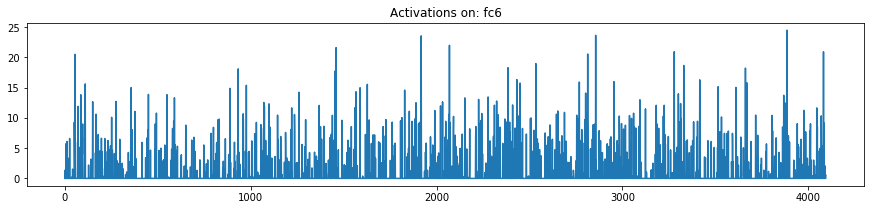

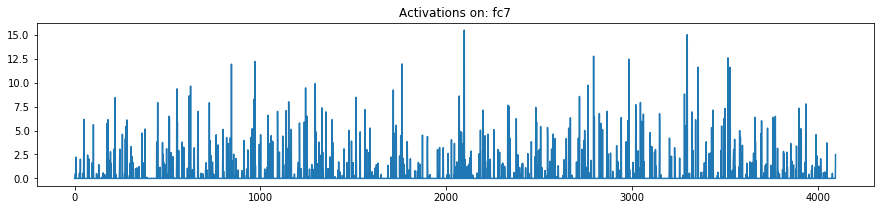

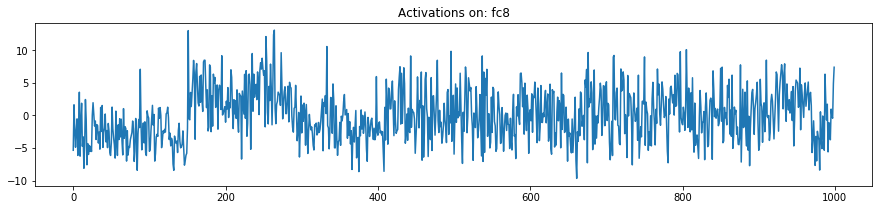

In [19]:
import functools

# Re-define the model to clear any previously registered hooks
model = alexnet(pretrained=True, num_classes=1000)

# Define a hook that visualizes a layer output
def show_activations_hook(name, module, input, output):
  
  print(f"Visualizing layer: {name}")
  # For conv/relu layer outputs (BxCxHxW) we plot an image as before
  if output.dim() == 4:
    vis_square(output, f"Activations on: {name}")
  
  # For linear layer outputs, we plot the activations as a line plot
  else:
    feat = output.data.view([-1]).cpu().numpy()
    plt.figure(figsize=(15, 3))
    plt.plot(feat)
    plt.title(f"Activations on: {name}")
  
# Register the hook on the select set of modules
for name, module in model.shortcut_modules():
  hook = functools.partial(show_activations_hook, name)
  module.register_forward_hook(hook)
  
# PyTorch modules work on minibatches and expect the first axis to be the batch axis
# If we run a model on a single image, we must turn this into a batch of size 1
model_input = Variable(example_image[np.newaxis, ...])

# Run the forward pass on the model
class_activations = model(model_input)[0]

### ?? Question ??

Consider the visualizations produced by the above cell. Why does `fc8` have negative values, but `fc6` and `fc7` are only positive?

HINT: Look at the structure of the network above, and our selection of named layers in `AlexNet.module_shortcuts`.

###**<font color='red' size='3em'>TODO 1: Write your answer in the "Student Implementations" cell as a comment</font>**

## Looking up the class names

The AlexNet model above outputs unconstrained class "scores". To turn these scores into a valid probability distribution over the 1000 ImageNet classes, we apply the softmax activation. We can find the index of the class with the maximum score and map that back to a description of the class in words.

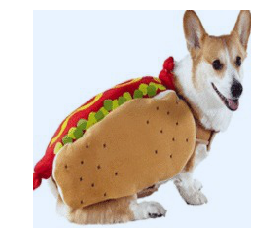

Loading pre-trained weights from model zoo
Predicted class: 264 - Cardigan, Cardigan Welsh corgi with probability 0.2899864614009857


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [20]:
# Load the image of the hot dog
example_image, label = dog_dataset[10]
show_image(example_image)

# Re-define the model to clear any previously registered hooks
model = alexnet(pretrained=True, num_classes=1000)

# Set to eval mode to disable dropout
model.eval()

model_input = example_image[np.newaxis, ...]

model_input = model_input.clone()

# Run the forward pass on the model
class_activations = model(Variable(model_input))[0]

# Compute class probabilities
class_probs = F.softmax(class_activations, dim=0)

# Get the class index
prob, class_idx = torch.max(class_probs, 0)

# Take the integer index out of the variable and tensor
class_idx = class_idx.data[0]

predicted_class_name = labels_id2word[class_idx]
print(f"Predicted class: {class_idx} - {predicted_class_name} with probability {prob.data[0]}")

** What to expect **

We can see that this example was correctly classified, and with high confidence, despite the dog wearing a misleading costume!

# 2. Dog vs Food: Classification

Let's classify dog vs food. We have prepared a test set of dogs dressed up like hotdogs, and hotdogs cut to look like animals.
The below cell visualizes all the images in our dataset:

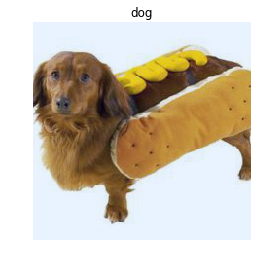

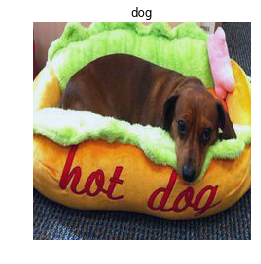

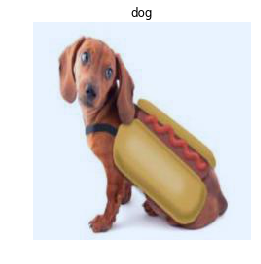

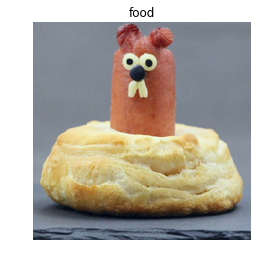

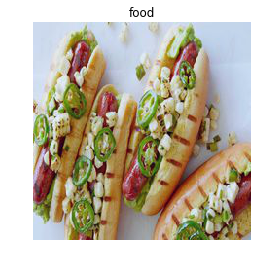

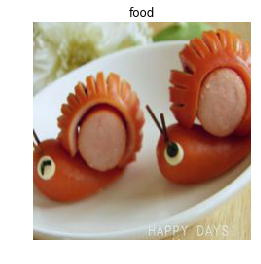

In [21]:
classes = ['dog', 'food']
class_datasets = [dog_dataset, food_dataset]

for cidx, cname in enumerate(classes):
  for i, (image, label) in enumerate(class_datasets[cidx]):
    if i >= 3:
      break
    show_image(image, classes[label])

### Repurposing the ILSVRC2012 Classifier

AlexNet was trained to recognize one of 1000 classes. We can repurpose it for our "food vs dog" task by remapping the categories.

###**<font color="red">TODO 2: Implement `convert_ilsvrc2012_probs_to_dog_vs_food_probs`</font>**

In [27]:
# Re-define the model to clear any previously registered hooks
model = alexnet(pretrained=True, num_classes=1000)
N = len(full_dataset)

dataloader = DataLoader(
    full_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=False)

assert len(dataloader) == 1, "Since batch_size is bigger than the number of examples, we should only have one batch"

for batch in dataloader:
  images = batch[0]
  labels = batch[1]
  labels_np = labels.numpy()
  
  class_activations = model(Variable(images))
  ilsvrc_class_probs = F.softmax(class_activations, dim=1)
  
  # Convert from Variable containing FloatTensor to numpy ndarray
  ilsvrc_class_probs_np = ilsvrc_class_probs.data.cpu().numpy()

  dogfood_class_probs_np = convert_ilsvrc2012_probs_to_dog_vs_food_probs(ilsvrc_class_probs_np)

  assert list(dogfood_class_probs_np.shape) == [N, 2]
  
  np.testing.assert_almost_equal(np.sum(dogfood_class_probs_np, axis=1), np.ones(N), decimal=5)
  
  print("Seems correct!")

Loading pre-trained weights from model zoo
[2.73335283e-03 7.43795410e-02 2.08995683e-04 4.74805391e-04
 4.60026844e-04 2.55398825e-02 1.42437627e-03 1.10258646e-02
 1.59011390e-02 1.20361557e-03 1.39190862e-03 1.68095910e-04
 1.02191500e-03 1.20593657e-04 2.97505612e-05 2.66783085e-04
 1.15733140e-03 4.57272581e-05 3.46311463e-05 9.55822179e-05
 3.47820605e-05 2.82106426e-04 3.01154050e-05 1.21991627e-03
 6.12069925e-05 1.13885123e-02 7.13821827e-03 5.04565202e-02
 2.17922707e-03 2.00538095e-02 8.19517998e-04 3.70909367e-03
 5.18774427e-03 5.57599887e-02 5.90883056e-03 4.34606746e-02
 1.73017643e-02 6.36306824e-03 7.58290151e-03 1.59653148e-03
 8.28944176e-05 3.88639863e-04 1.67113694e-03 3.36538954e-03
 7.58681737e-04 1.80945883e-03 7.39550451e-05 1.14102231e-03
 7.65993973e-05 3.12948629e-04 3.25683883e-04 1.85193513e-02
 1.00048818e-02 6.91700913e-03 1.59445859e-03 1.11124747e-04
 3.36335856e-03 3.70338472e-04 1.69274630e-04 7.80122774e-03
 1.04120551e-02 1.36800641e-02 9.36747994e

AssertionError: 
Arrays are not almost equal to 5 decimals

(mismatch 100.0%)
 x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])
 y: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

### Measuring the accuracy

You should expect to get ~90% accuracy for dogs and ~96% accuracy for food with an overall accuracy of 93%.


In [0]:
predicted_class = np.argmax(dogfood_class_probs_np, axis=1)
correct_mask = predicted_class == labels_np
num_correct = np.sum(correct_mask)
accuracy = 100.0 * float(num_correct) / N

print(f"Overall accuracy {accuracy} {num_correct} / {N}")

for cidx, cname in enumerate(classes):
  cls_mask = labels_np == cidx
  predicted_cls = predicted_class[cls_mask]
  num_correct = np.sum(predicted_cls == cidx)
  cls_acc = 100.0 * float(num_correct) / cls_mask.sum()

  print(f"{cname} class accuracy {cls_acc} {num_correct} / {cls_mask.sum()}")

# 3. Dog vs Food: Visualization

We can sort the predictions by the "dog" score and "food" score. The images are sorted according to how much AlexNet thinks the image belongs to that category.

Images are colored green/red depending on whether the prediction was correct.

For this assignment, you should expect that the incorrect predictions are all near the bottom (with the lowest score). This is a property that is very desirable -- mistakes only happen with lower scores. Note that in general real-world tasks, this does not always happen for free. If you want to be able to estimate the confidence of being correct, you need to separately predict that, and it is not easy to predict.

###**<font color="red"> TODO 3: Implement get_prediction_descending_order_indices </font>**

In [0]:
for cidx, cname in enumerate(classes):
  print(f"Predictions for class: {cname}")
  cls_mask = labels_np == cidx
  predicted_cls = predicted_class[cls_mask]
  cls_probs = dogfood_class_probs_np[cls_mask]
  correct = [p == cidx for p in predicted_cls]
  
  cls_images = [images[i] for i in range(len(images)) if cls_mask[i]]
  
  order = get_prediction_descending_order_indices(cls_probs, cidx)
  
  assert len(order) == cls_mask.sum()
  
  show_images(
    images = [cls_images[i] for i in order],
    correct_list = [correct[i] for i in order],
    titles = [f"Prob: {cls_probs[i, cidx]}" for i in order],
    size=128
  )

# 4. Visualizing saliency
Using our pre-trained AlexNet, we will compute class saliency maps as described in Section 3.1 of [2]. As mentioned in Section 2 of the paper, you should compute the gradient with respect to the image of the unnormalized class score (fc8), not of the normalized class probability (prob). You will need to use the backward method of the module to compute gradients with respect to the image.

We want to compute: $${\partial s_y \over \partial I}$$

where $s_y$ is the score for class $y$ after layer fc8, but before applying the Softmax layer.

We will then visualize the squared magnitude of this (max across color channels), to estimate the saliency of the class across the input image. See [1] for more details and intuition.



###**<font color="red">TODO 4: Implement compute_dscore_dimage</font>**

NOTE: You don't need to call model() in your function; this has already been run for you. Same for all gradient functions you implement below.

[[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.](http://arxiv.org/pdf/1312.6034.pdf)

In [0]:
model = alexnet(pretrained=True)

def visualize_saliency(image):
    image_in = Variable(image.unsqueeze(0), requires_grad=True)
    cls_scores = model(image_in)[0]
    max_score, max_idx = torch.max(cls_scores, 0)
  
    grad = compute_dscore_dimage(cls_scores, image_in, max_idx)
    
    vis = grad * grad
    vis, _ = torch.max(vis, 0)
    
    return vis

class_datasets = [dog_dataset, food_dataset]
  
num_images = 6
for cidx, cname in enumerate(classes):
  
  print(f"Saliency for class: {cname}")
  in_images = []
  vis_images = []
  
  for i, sample in enumerate(class_datasets[cidx]):
    image_i = sample[0]
    label_i = sample[1]
  
    vis_image = visualize_saliency(image_i)
    
    assert list(vis_image.shape) == [224, 224]
    
    vis_images.append(vis_image.unsqueeze(0))
    in_images.append(image_i)
    if i >= num_images:
      break
  
  row_list = list(zip(in_images, vis_images))
  
  show_image_rows(row_list)
  
  cls_mask = labels_np == cidx
  predicted_cls = predicted_class[cls_mask]
  cls_probs = dogfood_class_probs_np[cls_mask]

# 5. Fooling AlexNet
For many machine learning models, it is possible to "fool" them by tweaking the image slightly so that the image is predicted to become any category [1]. Given any image, and any target class, you can perform gradient ascent to maximize the score of that target class (equivalently, gradient descent on the negative score of that class), stopping when the network confidently predicts it as the target class.

Again, maximize the score with respect to the unnormalized class score (fc8) and not the normalized class probability (prob).

In addition to maximizing the score (minimizing the negative score), also add a regularizer that computes the L2 norm between the original image, and the fooling image. The final gradient will be the sum of the gradient from the regularizer and the gradient from maximizing the class score.

We can write this as a loss $L$: $$
L = -s_y(I) + R(I)
$$

where $$
R(I) = 0.5 \lambda \|I - I_\text{orig}\|_2^2
$$$y$ is the target class, and $\lambda$ is the regularization.

**Momentum**

When optimizing functions with ConvNets, typically you use use gradient descent with momentum, which has the update rule: $$V_t = \mu V_{t-1} - \alpha G$$$$I_t = I_{t-1} + V_{t}$$

where $V$ is the velocity, $\alpha$ is the learning rate, $\mu$ is the momentum parameter, $t$ is the iteration number, and $G = \frac{\partial L}{\partial I_{t-1}}$ is the gradient.

To improve stability, we will use a slightly different update, which normalizes the gradient $G$ to have unit norm: $$V_t = \mu V_{t-1} - \alpha \frac{G}{\|G\|}$$$$I_t = I_{t-1} + V_{t}$$

[1] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

###**<font color="red">TODO 5a: Implement the above update rule, normalized_sgd_with_momentum_update</font>**

###**<font color="red">TODO 5b: Implement fooling_image_gradient which returns the gradient of the loss with respect to the image $({\partial L \over \partial I})$.**

In [0]:
model = alexnet(pretrained=True)

# Set the model to eval mode
model.eval()

def make_fooling_image(image, target_class, learning_rate, regularization,
                       num_iter, momentum, threshold=0.9):
    """
    Fool AlexNet into thinking that any image has a particular class, by perturbing it just a little bit
    
    :param image: starting image CxHxW tensor
    :param target_class: the class that this will become after optimization
    :param learning_rate: either a constant, or a function that returns the learning rate at each iteration
    :param regularization: lambda parameter to multiply the regularizer
    :param num_iter: maximum number of iterations
    :param momentum: amount of momentum to use in the SGD 
    :param threshold: the target score for target_class
    """
    # Create batch dimension and turn into a variable
    image = image[np.newaxis, ...]
    
    print(f"Fooling AlexNet into thinking this is a: {labels_id2word[target_class]}")
    
    # This is the original image (used by the regularizer)
    orig_data = Variable(image.clone())
    
    image_in = Variable(image, requires_grad=True)
    velocity = torch.zeros_like(image_in)
        
    for i in range(num_iter):
        curr_scores = model(image_in)[0]
        curr_probs = F.softmax(curr_scores, 0)
        
        target_prob = curr_probs[target_class]
        target_score = curr_scores[target_class]
                
        # compute the gradient
        grad_wrt_image = fooling_image_gradient(
            target_score, orig_data, image_in, target_class, regularization)
        
        # update the image with the SGD rule
        image_in, velocity = normalized_sgd_with_momentum_update(
            image_in, grad_wrt_image, velocity, momentum, learning_rate)
        
        # Detach the image and velocity so that we don't backprop through
        # multiple iterations of the loop
        image_in = Variable(image_in.data, requires_grad = True)
        velocity = Variable(velocity.data, requires_grad = False)
        
        # Zero the gradients
        model.zero_grad()
        
        # Take the target probability out of the variable (turn it into float)
        target_prob = target_prob.data[0]
        
        # visualize the current state
        print(f"({i+1}/{num_iter}), {target_prob * 100} confidence")
        
        if target_prob > threshold:
            break
    
    delta = (image_in - orig_data).data
    return image_in, delta


num_images = 2
target_class=113
for cidx, cname in enumerate(classes):
    dataset = class_datasets[cidx]
    
    images_in = []
    fooling_images = []
    deltas = []
    
    for i, input in enumerate(dataset):
      image_in = input[0]
      label = input[1]
      
      fooling_image, delta = make_fooling_image(
          image_in,
          target_class=target_class,
          learning_rate=1e-1,
          regularization=5e-5,
          num_iter=100,
          momentum=0.9)
      
      delta = 0.5 + (5.0/255.0) * delta
    
      images_in.append(image_in)
      fooling_images.append(fooling_image)
      deltas.append(delta)
    
      if i >= num_images:
        break
        
    print ("\nLeft: original, middle: fooling image, right: difference magnified by 5x (gray is 0).\n"
        "AlexNet will classify the middle image in each row as %r with high confidence" % (
        labels_id2word[target_class]))
    show_image_rows(list(zip(images_in, fooling_images, deltas)))

# 6. Class visualization
We can visualize the knowledge inside AlexNet by starting with random noise and maximizing the probability of a certain class [2, 4]. This is similar to the idea of making a "fooling" image, except that the regularizer is a little different.

Again, we can write this as a loss $L$ depending on the image $I$: $$
L = -s_y(I) + R(I)
$$

where $$
R(I) = 0.5 \lambda \|I\|_2^2
$$$y$ is the target class, and $\lambda$ is the regularization.

[[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.](http://arxiv.org/pdf/1312.6034.pdf)

[[4] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop](http://arxiv.org/pdf/1312.6034.pdf)

###**<font color="red">TODO 6: Implement class_visualization_gradient: compute the gradient of the loss $({\partial L \over \partial I})$**

In [0]:
model = alexnet(pretrained=True)

# Set the model to eval mode
model.eval()

def make_class_visualization(target_class, learning_rate, regularization, num_iter,
                             max_jitter, blur_sigma, momentum):
    """
    Visualize an ILSVRC2012 class by maximizing the probability of that class, starting from random.
    
    :param target_class: what ILSVRC2012 class to visualize
    :param learning_rate: either a constant, or a function that returns the learning rate at each iteration
    :param regularization: lambda parameter to multiply the regularizer
    :param num_iter: number of iterations
    :param max_jitter: amount of jitter to add for regularization
    :param blur_sigma: blur each iteration by this amount.
    :param momentum: amount of momentum to use in the SGD update
    """
    
    image_np = 100 * np.random.randn(1, 3, 224, 224).astype(np.float32)
    vel_np = np.zeros_like(image_np)
    
    print(f"Generating visualization of: {labels_id2word[target_class]}...")
    
    for i in range(num_iter):
        # Random jitter to regularize
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        
        image_np = np.roll(np.roll(image_np, ox, -1), oy, -2)
        vel_np = np.roll(np.roll(vel_np, ox, -1), oy, -2)
        
        image = Variable(torch.from_numpy(image_np), requires_grad=True)
        velocity = Variable(torch.from_numpy(vel_np), requires_grad=False)
        
        # Compute the current class score
        class_scores = model(image)[0]
        class_probs = F.softmax(class_scores, 0)
        
        target_score = class_scores[target_class]
        target_prob = class_probs[target_class]
                
        # Compute the gradient
        grad = class_visualization_gradient(
            target_score, image, target_class, regularization)
        
        # Normalized SGD+Momentum update
        image, velocity = normalized_sgd_with_momentum_update(
            image, grad, velocity, momentum, learning_rate)
        
        # Convert back to numpy
        image_np = image.data.cpu().numpy()
        vel_np = velocity.data.cpu().numpy()
        
        # Undo jitter
        image_np = np.roll(np.roll(image_np, -ox, -1), -oy, -2)
        vel_np = np.roll(np.roll(vel_np, -ox, -1), -oy, -2)
        
        # blur the image every iteration
        for c in range(3):
            image_np[0, c, ...] = gaussian_filter(image_np[0, c, ...], sigma=blur_sigma)
        
        # Convert to float
        target_prob = target_prob.data[0]
        target_score = target_score.data[0]
        
        # Visualize our current result
        print(f"({i+1}/{num_iter}), {target_prob * 100} % confidence, score: {target_score}")
    
    return torch.from_numpy(image_np)[0]

## Generate images!
Use make_class_visualization to visualize an example Flamingo or Tarantula. You can play around with the hyperparameters or generate new classes, but you must at least generate a Flamingo or Tarantula.

The list of classes is in ~/caffe/data/ilsvrc12/synset_words.txt (this is downloaded in a cell above).

In [0]:
target_class = 130 # flamingo
image = make_class_visualization(
    target_class=target_class,
    learning_rate=200,
    regularization=1e-7,
    num_iter=250,
    max_jitter=5,
    blur_sigma=0.4,
    momentum=0.9,
)

show_image(image, f"Visualization for: {labels_id2word[target_class]}")

In [0]:
target_class = 76 # tarantula
image = make_class_visualization(
    target_class=target_class,
    learning_rate=200,
    regularization=1e-7,
    num_iter=250,
    max_jitter=5,
    blur_sigma=0.4,
    momentum=0.9,
)

show_image(image, f"Visualization for: {labels_id2word[target_class]}")

In [0]:
# Try other classes here

# 7. Feature Inversion
Instead of generating new examples, we can try and reconstruct examples starting from the hidden representation of a single layer [5]. While [4] and [5] use better regularizers, we are going to use a simple L2 regularizer.

Concretely, given a image $I$, let $\phi_\ell(I)$ be the activations at layer $\ell$ of the convolutional network $\phi$. We wish to find an image $I$ with a similar feature representation as $I'$ at layer $\ell$ of the network $\phi$ by solving the optimization problem

$$
L = (0.5/M) \|\phi_\ell(I) - \phi_\ell(I')\|_2^2 + R(I)
$$

where $\|\cdot\|_2^2$ is the squared Euclidean norm, and $M$ is the number of entries in $\phi_\ell(I)$.  $M$ was added to make it easier to set $\lambda$, and  $R(I)$ is a regularizer. We can solve this optimization problem using gradient descent (with momentum), computing gradients with respect to the generated image. We will use L2 regularization of the form:

$$
R(I) = 0.5 \lambda \|I\|_2^2
$$

To improve the reconstruction quality, we will blur the image every few iterations, which is like adding an implicit regularizer to the optimization.

[5] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015

[4] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

###**<font color="red">TODO 7a: Implement feature_inversion_gradient, which computes the gradient of the above loss function with respect to the image, ${\partial L \over \partial I}$.</font>**

In [0]:
activations = None

def make_feature_inversion(image, layer_name, variable_learning_rate, regularization,
                           num_iter, blur_every, momentum):
    """
    Solve for a feature inversion for a given filename, by reconstructing from a certain layer (blob_name).
    :param image: FloatTensor of shape (3, 224, 224)
    :param variable_learning_rate: (int -> float) a function  that returns the learning rate at each iteration
    :param regularization: lambda parameter to multiply the regularizer
    :param num_iter: number of iterations
    :param blur_every: how many iterations to wait between blurring the image
    :param momentum: amount of momentum to use in the SGD update
    """
    
    model = alexnet(pretrained=True)
    
    # Define a hook that will capture the activations from the required layer
    def grab_activations_hook(module, input, output):
      print("Captured activations")
      global activations
      activations = output
    model.module_shortcuts[layer_name].register_forward_hook(grab_activations_hook)
    
    image = Variable(image.unsqueeze(0))
    
    class_scores = model(image)[0]
    
    # target feature value
    global activations
    target_feat = Variable(activations.data.clone())
    activations = None
    
    # start out with random gaussian noise
    data_np = 20 * np.random.randn(1, 3, 224, 224).astype(np.float32)
    
    # momentum velocity
    vel_np = np.zeros_like(data_np)
    
    print(f"Inverting features")
    
    for i in range(num_iter):
      
        data_in = Variable(torch.from_numpy(data_np), requires_grad=True)
        velocity = Variable(torch.from_numpy(vel_np), requires_grad=False)
      
        class_scores = model(data_in)[0]
        
        # learning rate: allow it to vary
        lr = variable_learning_rate(i)
        
        # current feature value
        cur_feat = activations[0].clone()
        activations = None
        
        grad, loss, loss_target, loss_reg = feature_inversion_gradient(
          data_in, target_feat, cur_feat, regularization
        )
        
        model.zero_grad()
                
        # Normalized SGD+Momentum update
        data_in, velocity = normalized_sgd_with_momentum_update(
            data_in.data, grad.data, velocity.data, momentum, lr)
                
        data_np = data_in.cpu().numpy()
        vel_np = velocity.cpu().numpy()
        
        # Periodically blur the image
        if i > 0 and i < num_iter - 1 and (i % blur_every) == 0:
            # Blur each color channel separately
            for c in range(3):
                data_np[0, c, ...] = gaussian_filter(data_np[0, c, ...], sigma=0.5)

        print(f"({i+1}/{num_iter}) Layer name: {layer_name}, learning_rate: {lr}, loss: {loss} ({loss_target} target + {loss_reg} reg)")        
    
    return data_in[0]

**Original image**

In [0]:
image, label = full_dataset[10]
show_image(image)

#### ** Reconstructed images**

HINT: If you read the paper by Mahendran and Vedaldi, you'll see that reconstructions from deep features tend not to look much like the original image, so you shouldn't expect the results to look like the reconstruction above. You should be able to get an image that shows some discernable structure within 100-1000 iterations.

conv1 should look pretty close to the original image.  conv1 should be pretty fast to compute (several iterations per second), but the later layers will be slower (1-5 seconds per iteration).

When debugging, we recommend making sure that conv1 works before trying the other layers.

In [0]:
LAYER_NAME = "conv1"

rec_image = make_feature_inversion(image,
           layer_name=LAYER_NAME,
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)

show_image(rec_image, f"Reconstruction for {LAYER_NAME}")

In [0]:
LAYER_NAME = "conv2"

rec_image = make_feature_inversion(image,
           layer_name=LAYER_NAME,
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)

show_image(rec_image, f"Reconstruction for {LAYER_NAME}")

In [0]:
LAYER_NAME = "conv3"

rec_image = make_feature_inversion(image,
           layer_name=LAYER_NAME,
           variable_learning_rate=lambda i: 100.0 * np.exp(-i/100.0),
           regularization=1e-7,
           num_iter=1000,
           blur_every=5,
           momentum=0.9)

show_image(rec_image, f"Reconstruction for {LAYER_NAME}")

In [0]:
LAYER_NAME = "conv4"

rec_image = make_feature_inversion(image,
           layer_name=LAYER_NAME,
           variable_learning_rate=lambda i: 100.0 * np.exp(-i/100.0),
           regularization=5e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)

show_image(rec_image, f"Reconstruction for {LAYER_NAME}")

In [0]:
LAYER_NAME = "conv5"

rec_image = make_feature_inversion(image,
           layer_name=LAYER_NAME,
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)

show_image(rec_image, f"Reconstruction for {LAYER_NAME}")

In [0]:
LAYER_NAME = "fc6"

rec_image = make_feature_inversion(image,
           layer_name=LAYER_NAME,
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)

show_image(rec_image, f"Reconstruction for {LAYER_NAME}")

In [0]:
LAYER_NAME = "fc8"

rec_image = make_feature_inversion(image,
           layer_name=LAYER_NAME,
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-10,
           num_iter=200,
           blur_every=5,
           momentum=0.9)

show_image(rec_image, f"Reconstruction for {LAYER_NAME}")

## Question

(a) What happens to the quality of the reconstruction as you reconstruct from higher layers? Why does this happen? What does this suggest about the representation at each layer?

(b) Why did we adjust the regularization parameter to a different value for some layers? How might the objective function be changed so that a different value isn't needed for each layer?

### **<font color="red">TODO 7b: Answer in solution cell as a comment.</font>**

# Test cases
## Run These blocks to test your code

### Helper functions

In [0]:
import io
base_dir = "http://www.cs.cornell.edu/courses/cs5670/2018sp/projects/"
def _load(fname):
    """ Helper to load compressed .npz arrays """
    f = urllib.request.urlopen(base_dir+fname).read()
    f = io.BytesIO(f)
    return np.load(f)['arr_0']


def relative_error(expected, actual, epsilon=1e-5):
    """ Mean relative error between two arrays """
    return np.mean(
        np.abs(expected - actual) /
        np.maximum(np.abs(actual), epsilon)
    )

### Test `compute_dscore_dimage`

In [0]:
net = alexnet(pretrained=True)
THRESH = 1e-2
def test_compute_dscore_dimage():
    image = _load("expected/data.npz")
    expected =  _load("expected/compute_dscore_dimage-grad.npz")
    image = torch.from_numpy(image).unsqueeze(0)    
    image_in = Variable(image, requires_grad=True)
    cls_scores = net(image_in)[0]
    actual_grad = compute_dscore_dimage(cls_scores, image_in, 254)

    # relative error must be small
    assert relative_error(expected, actual_grad.data.numpy()) < THRESH
    print("Passed!")
test_compute_dscore_dimage()

### Test `normalized_sgd_with_momentum_update`

In [0]:
net = alexnet(pretrained=True)
THRESH = 1e-2
def test_normalized_sgd_with_momentum_update():
    image = _load("expected/data.npz")
    grad = _load('expected/normalized_sgd_with_momentum_update-grad.npz')
    velocity = _load('expected/normalized_sgd_with_momentum_update-velocity.npz')
    expected_data = _load('expected/normalized_sgd_with_momentum_update-new_data.npz')
    expected_velocity = _load('expected/normalized_sgd_with_momentum_update-new_velocity.npz')
    
    image = torch.from_numpy(image).unsqueeze(0)
    image = Variable(image, requires_grad=True)

    grad = torch.from_numpy(grad).unsqueeze(0)
    grad = Variable(grad, requires_grad=True)

    velocity = torch.from_numpy(velocity).unsqueeze(0)
    velocity = Variable(velocity, requires_grad=True)

    momentum = 0.99
    learning_rate = 100
    new_data, new_velocity = normalized_sgd_with_momentum_update(
        image, grad, velocity, momentum, learning_rate)
    
    # relative error must be small
    assert relative_error(expected_data, new_data.data.numpy()) < THRESH
    assert relative_error(expected_velocity, new_velocity.data.numpy()) < THRESH
    print("Passed!")
test_normalized_sgd_with_momentum_update()

### Test `fooling_image_gradient`

In [0]:
net = alexnet(pretrained=True)
THRESH = 1e-2
def test_fooling_image_gradient():
    image = torch.from_numpy(_load("expected/data.npz")).unsqueeze(0)
    image = Variable(image, requires_grad=True)

    new_image = torch.from_numpy(\
            _load("expected/normalized_sgd_with_momentum_update-new_data.npz"))
    new_image = Variable(new_image, requires_grad=True)
    
    curr_scores = net(new_image)[0]
    target_score = curr_scores[113]
    regularization = 1e-3
    
    target_grad = fooling_image_gradient(target_score, image, new_image, target_class, regularization)
    expected = _load('expected/fooling_image_gradient-grad.npz')
    assert relative_error(expected, target_grad.data.numpy()) < THRESH
    print("Passed!")
    
test_fooling_image_gradient()

### Test `test_class_visualization_gradient`

In [0]:
net = alexnet(pretrained=True)
THRESH = 1e-2
def test_class_visualization_gradient():
    image = torch.from_numpy(_load("expected/feature_inversion_gradient-cur_data.npz")).unsqueeze(0)
    image = Variable(image, requires_grad=True)
    
    target_class = 130
    class_scores = net(image)[0]
    target_score = class_scores[target_class]
    regularization = 1e-3

    grad = class_visualization_gradient(target_score, image, target_class, regularization)
    
    expected = _load('expected/feature_inversion_gradient-grad.npz')
    assert relative_error(expected, grad.data.numpy()) < THRESH
    print("Passed!")
test_class_visualization_gradient()
